In [ ]:
!pip uninstall -y opencv-python opencv-python-headless mediapipe protobuf


Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5


In [ ]:
!pip install numpy==1.26.4
!pip install protobuf==4.25.3
!pip install opencv-python==4.9.0.80
!pip install mediapipe==0.10.20


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, which is not installed.
tensorflow-datasets 4.9.9 requires protobuf>=3.20, which is not installed.
tensorboard 2.19.0 requires protobuf!=4.24.0,>=3.19.6, which is not installed.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
tensorflow-hub 0.16.1 requires protobuf>=3.19.6,

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.3 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 13.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling opencv-contrib-python-4.12.0.88:
      Successfully uninstalled opencv-contrib-python-4.12.0.88
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Unins

In [ ]:
import cv2
import mediapipe as mp

print("OpenCV:", cv2.__version__)
print("Mediapipe:", mp.__version__)


OpenCV: 4.11.0
Mediapipe: 0.10.20


Importing Libraries

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input


Loading Model

In [ ]:
model = load_model("/content/derma_model.h5")

class_dict = {
    0: "clear_skin",
    1: "dark_spots",
    2: "puffy_eyes",
    3: "wrinkles"
}


Setup Haarcascade & Mediapipe

In [ ]:
haar = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

mp_face = mp.solutions.face_detection


Prediction Function

In [ ]:
def predict_skin(face_img):
    img = cv2.resize(face_img, (224,224))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)[0]
    cls = np.argmax(preds)
    conf = preds[cls] * 100
    return class_dict[cls], float(conf)


Face Detection (Haarcascade → Mediapipe fallback)

In [ ]:
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Try Haarcascade
    faces = haar.detectMultiScale(gray, 1.05, 4, minSize=(24,24))

    if len(faces) > 0:
        return faces, "haar"

    # Fallback: Mediapipe
    mp_faces = []
    h, w = image.shape[:2]

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.45) as detector:
        result = detector.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if result.detections:
            for det in result.detections:
                box = det.location_data.relative_bounding_box
                x = int(box.xmin * w)
                y = int(box.ymin * h)
                w_box = int(box.width * w)
                h_box = int(box.height * h)
                mp_faces.append([x, y, w_box, h_box])

    return mp_faces, "mediapipe"


Process Folder & Save Results

In [ ]:
input_folder = "/content/drive/MyDrive/Colab Notebooks/Testing"
annotated_folder = "/content/annotated_faces"
cropped_folder = "/content/cropped_faces"

os.makedirs(annotated_folder, exist_ok=True)
os.makedirs(cropped_folder, exist_ok=True)

csv_records = []


Loop Over All Images

In [ ]:
for filename in os.listdir(input_folder):

    if not filename.lower().endswith((".jpg",".png",".jpeg")):
        continue

    path = os.path.join(input_folder, filename)
    img = cv2.imread(path)
    orig = img.copy()

    faces, method = detect_faces(img)

    for idx, (x,y,w,h) in enumerate(faces):
        x, y = max(0,x), max(0,y)
        face_crop = orig[y:y+h, x:x+w]

        if face_crop.size == 0:
            continue

        label, conf = predict_skin(face_crop)

        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(img, f"{label} {conf:.1f}%", (x,y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

        crop_path = os.path.join(cropped_folder, f"{filename}_face{idx}.jpg")
        cv2.imwrite(crop_path, face_crop)

        csv_records.append([filename, label, round(conf,2), method])

    save_path = os.path.join(annotated_folder, filename)
    cv2.imwrite(save_path, img)

    print(f"Processed: {filename}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processed: 5c208564-c800-478c-8518-a639c20cd8c9.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Processed: 4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Processed: 15.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Processed: 42.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Processed: 14.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Processed: 30.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Processed: 23.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Processed: clear_aug_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Processed: 13.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Processed: 21.jpg


Export CSV

In [ ]:
df = pd.DataFrame(csv_records,
                  columns=["image_name","predicted_label","confidence","detection_method"])

df.to_csv("/content/predictions.csv", index=False)

df.head(10)


,image_name,predicted_label,confidence,detection_method
0,5c208564-c800-478c-8518-a639c20cd8c9.jpg,dark_spots,76.15,haar
1,4.jpg,dark_spots,72.78,haar
2,15.jpg,puffy_eyes,69.94,haar
3,42.jpg,puffy_eyes,46.98,haar
4,14.jpg,wrinkles,54.20,mediapipe
5,30.jpg,wrinkles,99.27,haar
6,23.jpg,wrinkles,97.15,haar
7,clear_aug_0086.jpg,clear_skin,56.56,haar
8,13.jpg,clear_skin,40.98,haar
9,13.jpg,wrinkles,56.72,haar


Zip file for annotated images

In [ ]:
import shutil
from google.colab import files

shutil.make_archive("/content/cropped_faces", 'zip', "/content/cropped_faces")
files.download("/content/cropped_faces.zip")

shutil.make_archive("/content/annotated_faces", 'zip', "/content/annotated_faces")
files.download("/content/annotated_faces.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MEDIAPIPE DETECTION

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Detected using: Mediapipe
Prediction: wrinkles (58.35%)
All class probabilities:
  clear_skin: 14.69%
  dark_spots: 6.19%
  puffy_eyes: 20.77%
  wrinkles: 58.35%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Detected using: Mediapipe
Prediction: wrinkles (74.88%)
All class probabilities:
  clear_skin: 7.96%
  dark_spots: 4.26%
  puffy_eyes: 12.89%
  wrinkles: 74.88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Detected using: Mediapipe
Prediction: wrinkles (64.53%)
All class probabilities:
  clear_skin: 4.51%
  dark_spots: 12.27%
  puffy_eyes: 18.69%
  wrinkles: 64.53%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Detected using: Mediapipe
Prediction: wrinkles (70.38%)
All class probabilities:
  clear_skin: 7.34%
  dark_spots: 7.09%
  puffy_eyes: 15.20%
  wrinkles: 70.38%


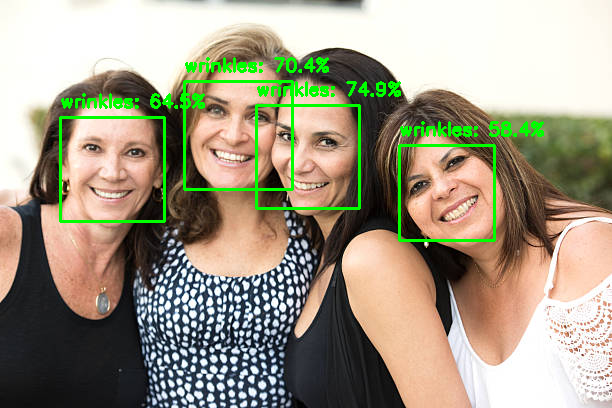

In [ ]:
from google.colab.patches import cv2_imshow
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

def detect_faces(img):
    faces = []
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_detection.process(rgb_img)
        if results.detections:
            for det in results.detections:
                bboxC = det.location_data.relative_bounding_box
                ih, iw, _ = img.shape
                x = int(bboxC.xmin * iw)
                y = int(bboxC.ymin * ih)
                w = int(bboxC.width * iw)
                h = int(bboxC.height * ih)
                faces.append((x, y, w, h))
            return faces, "Mediapipe"
    return faces, "Mediapipe"

def predict_skin(face_img):
    img = cv2.resize(face_img, (224,224))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)[0]
    cls = np.argmax(preds)
    conf = preds[cls] * 100
    return class_dict[cls], float(conf), preds

IMAGE_PATH = "/content/4.jpg"
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise ValueError("Image not found")

faces, method = detect_faces(img)
annotated = img.copy()

if len(faces) == 0:
    print("No face detected")
else:
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        if face.size == 0:
            continue

        label, conf, probs = predict_skin(face)

        print(f"Detected using: {method}")
        print(f"Prediction: {label} ({conf:.2f}%)")
        print("All class probabilities:")
        for i, p in enumerate(probs):
            print(f"  {class_dict[i]}: {p*100:.2f}%")

        text = f"{label}: {conf:.1f}%"
        cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(annotated, text, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

cv2_imshow(annotated)
cv2.waitKey(0)
cv2.destroyAllWindows()